## Initial Brainstorming
I wanted my project to do three things. First, I wanted to build a model that could identify the number, size, and location of barnacles in an image with a high accuracy. Because there are only two annotated masks, I wanted my model to be able to be generalizable with little to no training data. Second, I wanted the output of this model to be able to be quickly edited and corrected. Third, I wanted to use these outputs in analysis and for visualizations.

## Critical Subtasks

#### (1) Separate image
Input: An image taken by researcher of barnacles with the green frame overlay. Example: "provided/img1.png"

Output: 9 image files, each a subregion of the image within the green frame. Each image should be in the form "img_{image number}_{region from 1-9}.png". Pixel to cm ratio.

This task would extract the inner region of the green frame from the image. I later learned that my model worked better when this inner region was further divided into smaller frames, so this task would also divide the inner region into 9 subregions. This task should also calculate the pixel:cm ratio by measuring the length of the shown ruler in pixels.

#### (2) Identify barnacles
Input: A subregion image file. Example: "subsections/train/img_1_1.jpg"

Output: A barnacle data file that contains the locations and sizes of the subregion in pixels.

This task would identify where the barnacles within an image are. It would output a file stating the center of each barnacle (x,y) and the size of the barnacle. 

#### (3) Correct barnacle identification
Input: A barnacle data file.

Output: A barnacle data file with manual corrections.

This task would allow a researcher to manually draw in missed barnacles and remove improperly drawn barnacles. This corrected data file could be used in further analysis.

#### (4) Reconnect image
Input: 9 barnacle data files that contain the coordinates and size of each barnacle within a subregion.

Output: 1 barnacle data file that combines the 9 data files according to their position within the inner region.

This task would use the data files and modify the coordinates based on each position so that the barnacle data for the entire inner region of an image is together and aligned.

#### (5) Analysis
Input: Barnacle data files

Output: Various plots to showcase the barnacle data.

This task would use the barnacle data files to return data such as the number of barnacles within an image and can run varied analysis on the images.

## Initial Prototyping

I started prototyping with unseen_img2.png. Initially, I looked at YOLO (you only look once object detection algorithm). While this looked like a good solution, I realized there were no good barnacle datasets. With only two masked images, it would require a lot of manual labor to annotate enough images to train a model that could work on a variety of barnacle sets (I ended up trying this in the Colab file). Thus, I started looking into unsupervised strategies. I tried using DBSCAN and Watershed algorithm, but neither seemed to be working the way I wanted them to.

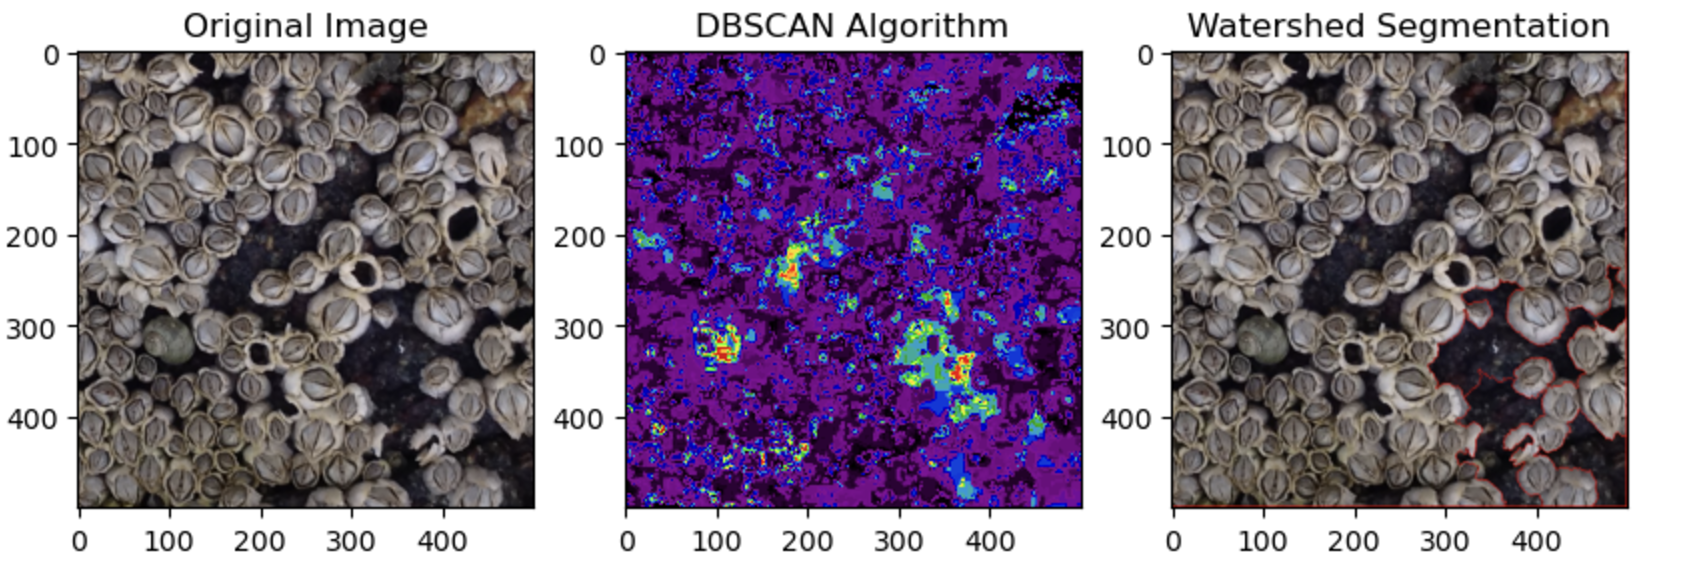

However, while testing watershed segmentation I realized that thresholded images made the image much simpler and more clear. I decided to threshold the images, then use OpenCV to identify circles on the thresholded image. This solution should be generalizable to almost any barnacle image and did not require any training data. 

In [1]:
import barnacle as bcl

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from PIL import Image

## Subtask 1: Separate image

To separate the image into nine inner regions, I provide the top left corner of each green frame and the length of the frame. Using this, I divide the inner region into nine subdivisions. The same top left corner and frame length are supplied to the mask, dividing it to match exactly for a ground truth file. Each subdivision is resized to be 500x500 pixels. Because the dimensions of the green frame are 11.5cm, each image is 3.8333 cm x 3.8333 cm. The pixel to cm ratio is 1500 px to 11.5 cm. I also separated unseen_img1.png, which was renamed img3. This was put in a test folder to validate the model later.

In [2]:
def separate_image(img, img_id, top_left, box_length):
    image = Image.open(img)
    img_left = top_left[0]
    img_top = top_left[1]

    subsection = 1
    for j in range(3):
        for i in range(3):
            left = img_left + i * int(box_length/3)
            top = img_top + j * int(box_length/3)
            right = left + int(box_length/3)
            bottom = top + int(box_length/3)

            crop = image.crop((left, top, right, bottom)).convert('RGB')

            resize = crop.resize((500, 500))
            
            resize.save(f"subsections/{img_id}_{subsection}.jpg")
            subsection += 1
    # saves cropped image to demo folder
    crop = image.crop((img_left, img_top, img_left+box_length, img_top+box_length))
    resize = crop.resize((1500,1500))
    resize.save(f"demo/{img_id.split("/")[1]}.png")

In [3]:
separate_image("provided/img1.png", "train/img_1", (1098,469), 1497)
separate_image("provided/mask1.png", "train/mask_1", (1098,469), 1497)

separate_image("provided/img2.png", "train/img_2", (935,204), 1659)
separate_image("provided/mask2.png", "train/mask_2", (935,204), 1659)

separate_image("provided/unseen_img1.png", "test/img_3", (998,176), 1591)

## Subtask 2: Identify barnacles

The barnacle identification required two steps. First, process the image to make it easier to detect circles, and second, run the circle detection algorithm. This should be able to identify any circular shaped barnacle. I tried a variety of preprocessing transformations and eventually settled on converting to grayscale, sharpening with a kernel, and thresholding with Otsu's method.

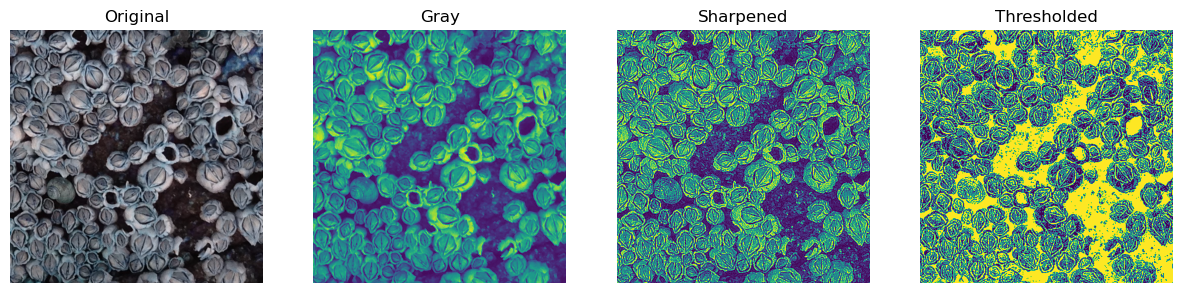

In [4]:
image = cv2.imread("provided/unseen_img2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.array([[-2, -2, -2], [-2, 17, -2], [-2, -2, -2]]) 
sharpened_image = cv2.filter2D(gray, -1, kernel) 
_, thresh = cv2.threshold(sharpened_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(15, 8))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.axis("off")
plt.title('Original')

plt.subplot(1, 4, 2)
plt.imshow(gray)
plt.axis("off")
plt.title('Gray')

plt.subplot(1, 4, 3)
plt.imshow(sharpened_image)
plt.axis("off")
plt.title('Sharpened')

plt.subplot(1, 4, 4)
plt.imshow(thresh)
plt.axis("off")
plt.title('Thresholded')

plt.show()

With the preprocessed image, we can now use OpenCV's HoughCircles method to identify the circles in the image. This method takes in a variety of parameters that dictate how circles are identified. This includes the minimum distance between circles and range of possible circle sizes, but also two more abstract parameters, param1 and param2. For our initial test, we set the parameters to what seem like reasonable values. The model outputs a prediction file that contains the estimated x, y, and r of each circle. Using that file, we can view our estimates overlayed on the original image.

281 circles found.


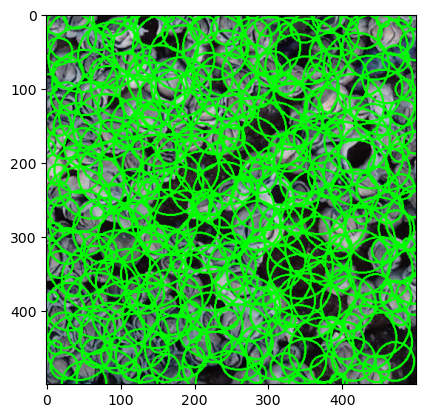

In [5]:
parameters = {
    "dp": 1,
    "minDist": 25,
    "param1": 150,
    "param2": 15,
    "minRadius": 3,
    "maxRadius": 45,
}
model = bcl.BarnacleModel(parameters)
print(f"{model.predict_single("provided/unseen_img2.png")} circles found.")
model.visualize_prediction("provided/unseen_img2.png")

Clearly, the model needs work. In order to improve our model, we need to score it based on its accuracy. There are multiple methods for this, but to keep things simple I measure the error between the number of barnacles predicted and number of barnacles actually present. To find the true barnacle count, I divide the mask image files to match the subsection images and use OpenCV to count the number of contours of each mask file. This matches each image file to a barnacle count. This resulted in 18 images and barnacle counts.

In [6]:
x_train = []
y_train = []

for f in glob.glob("subsections/train/img*"):
    img = f.split("train/")[1]
    img_id = img.split("_", 1)[1].split(".")[0]
    x_train.append(f)
    y_train.append(len(bcl.unique_contours(f"subsections/train/mask_{img_id}.jpg")))

print("Actual barnacle count of each subsection:")
print(y_train)

Actual barnacle count of each subsection:
[188, 167, 61, 35, 52, 45, 70, 51, 14, 53, 55, 200, 232, 209, 188, 186, 207, 194]


Now, by giving the model each image and the expected barnacle count, we can determine the error for each prediction. We then score the model by getting its average prediction error. Thus, a perfect score would be 0, and a score of 0.5 (50% error) would mean for an image with 100 barnacles, on average the prediction is about 50 or 150.

In [7]:
model.score(x_train, y_train)

3.2530190348918793

On average, this model has 325% error. Yikes. While this gives a good estimate of the quality of the model, I found that it was better to evaluate the model using F1 score. Rather than compare the number of barnacles estimated and actually present in the image, it marks each prediction as a true positive or false positive based on the predicted circle's size and location and if this overlaps an actual barnacle or not. To find the location and size of the actual barnacles, I used contour detection on the masked image and compared this with the predictions. The rest of this notebook evaluates based on F1 score (found with precise_score) and average error (found with score), but F1 is the primary evaluation metric.

In [8]:
model.precise_score(x_train)

0.32039378569796423

The model has a F1 score of 0.32, which is bad. Below shows the predictions for one barnacle image overlaid on to the mask file. The mask is in brown, and this image was preprocessed and analyzed to translate each barnacle outline to a black circle which represents the actual barnacle locations and sizes. The green circles are accurate predictions and the red circles are inaccurate predictions. This specific file has a F1 score of 0.39.

0.3982869379014989


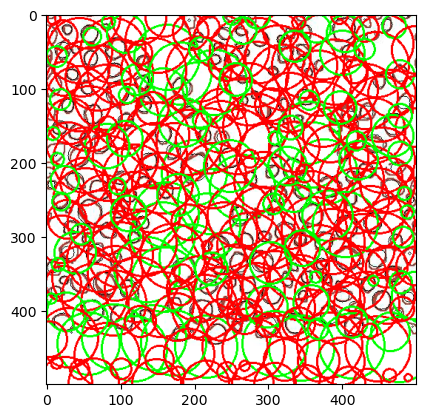

In [9]:
model.visualize_score(x_train[0])

To improve this model, I used Grid Search. This finds an optimal combination of parameters by running every parameter combination and comparing the scores. The below code runs 1800 simulations and takes about 8 minutes to run. This first block of code can be skipped as I have included the parameter scores in a csv in demo. To view the results of the code without waiting for the tuning to complete, run the second block.

In [19]:
sims = {}
sim = 0
dp = 1

for minDist in range (15,30,3):
    for minRadius in range(5,10,2):
        for maxRadius in range(15,26,5):
            for param1 in range(150,350,50):
                for param2 in range(15,25):
                    parameters = {
                        "dp": dp,
                        "minDist": minDist,
                        "param1": param1,
                        "param2": param2,
                        "minRadius": minRadius,
                        "maxRadius": maxRadius,
                    }
                    model = bcl.BarnacleModel(parameters)
                    # parameters["avg_error"] = model.score(x_train, y_train)
                    parameters["f1_score"] = model.precise_score(x_train)
                    if (sim%250 == 0):
                        print(sim)
                    sims[sim] = parameters
                    sim += 1

df = pd.DataFrame(sims).T
df = df.sort_values("f1_score", ascending=False)
df.to_csv("demo/parameter_scores.csv", index=False)

0
250
500
750
1000
1250
1500
1750


In [20]:
df = pd.read_csv("demo/parameter_scores.csv")
df

dp  minDist  param1  param2  minRadius  maxRadius  f1_score
0     1.0     21.0   150.0    19.0        7.0       20.0  0.662783
1     1.0     21.0   250.0    19.0        7.0       20.0  0.662783
2     1.0     21.0   300.0    19.0        7.0       20.0  0.662783
3     1.0     21.0   200.0    19.0        7.0       20.0  0.662783
4     1.0     24.0   150.0    19.0        7.0       20.0  0.657831
...   ...      ...     ...     ...        ...        ...       ...
1795  1.0     21.0   300.0    23.0        9.0       15.0  0.000553
1796  1.0     27.0   200.0    24.0        9.0       15.0  0.000553
1797  1.0     27.0   200.0    23.0        9.0       15.0  0.000553
1798  1.0     15.0   150.0    24.0        9.0       15.0  0.000553
1799  1.0     18.0   250.0    24.0        9.0       15.0  0.000553

[1800 rows x 7 columns]

Using this parameter tuning, we can get the F1 score up to 0.66. Looks like we are doing much better! We now have a set of parameters that looks effective. However, because the model is being scored on the images it was trained on (img1 and img2), it's possible that the model is overfit to the training data and is not actually generalizable. To fully test this, we can score the model based on img3, an image that it has not seen before and is not trained on. Because there is no mask for this image, I handcounted the number of barnacles in each subsection to determine the average error.

In [21]:
x_test = ["subsections/test/img_3_1.jpg", "subsections/test/img_3_2.jpg", "subsections/test/img_3_3.jpg",
          "subsections/test/img_3_4.jpg", "subsections/test/img_3_5.jpg", "subsections/test/img_3_6.jpg",
          "subsections/test/img_3_7.jpg", "subsections/test/img_3_8.jpg", "subsections/test/img_3_9.jpg"
         ]
y_test = [137, 148, 161, 180, 163, 149, 108, 123,102]

parameters = {
    "dp": 1,
    "minDist": 21,
    "param1": 250,
    "param2": 19,
    "minRadius": 7,
    "maxRadius": 20,
}
model = bcl.BarnacleModel(parameters)
model.score(x_test, y_test)

0.15390734115378105

To test on the unseen images, we evaluate using average error (as no mask exists for the F1 score) and find that the unseen images, we get an average error of only 15.3%! Much better than our initial 300%. Below is an example of the model being run on one of the subsections. 

0.7400611620795107


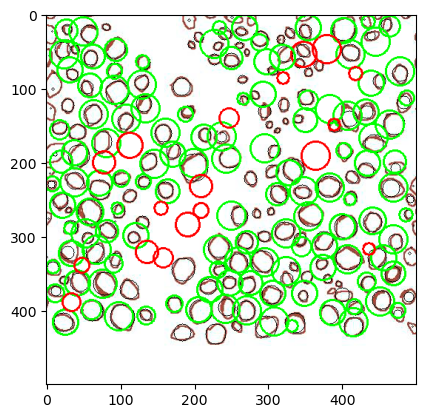

In [22]:
model.precise_score(x_train)
model.visualize_score(x_train[0])

Let's look at what the model estimates for unseen_img2 now.

116 circles found.


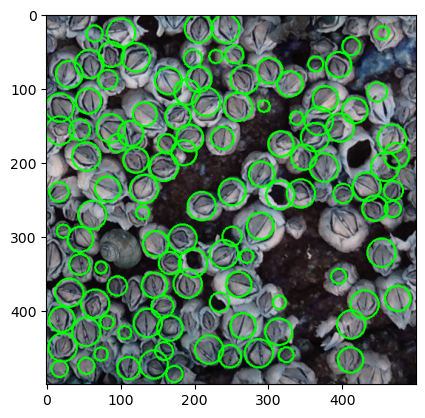

In [23]:
print(f"{model.predict_single("provided/unseen_img2.png")} circles found.")
model.visualize_prediction("provided/unseen_img2.png")

Overall, the model is able to identify barnacles with accuracy, but it's not perfect. To allow scientists to improve the accuracy of this tool, I've built an editor that allows scientists to modify the initial estimates of the algorithm and save it. In this way, the algorithm makes an initial pass at the barnacles, getting a singificant portion identified, and the scientist can fill in corrections to achieve the desired accuracy.

## Subtask 3: Correct barnacle identification

To edit a prediction, input the location of the image and its estimate file. The prediction can be modified in the editor. To **draw** a new circle, simply click and drag. To **delete** a circle, click the center of the circle. To **save** the prediction, press the s key. To **quit** the editor, press the q key. The editor must be closed in this way to avoid an error. The saved prediction file will now be used in downstream analysis.

In [24]:
editor = bcl.CircleViewer("img_1_1", "subsections/train/img_1_1.jpg", "output/est_img_1_1.txt")
editor.start()

2025-01-19 23:19:32.277 python[16837:28624907] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-19 23:19:32.277 python[16837:28624907] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## Subtask 4: Reconnect images
We now have a model that can detect barnacles and an editor that can correct the mistakes of that detection. This relied on splitting the image into nine subsections. We can combine the estimates of these subsections to find the estimate of the image as a whole. This will first check if there is an edited output, and if there is not, will access the original model output.

In [25]:
from barnacle import extract_circles
import os

# returns circle dict of img / subsection. Prioritizes edited version.
def get_estimate(image_id, subsection):
    location = f"edited_output/est_img_{image_id}_{subsection}.txt"
    if not os.path.exists(location):
        location = f"output/est_img_{image_id}_{subsection}.txt"
    return extract_circles(location,as_int=True)

def combine_image(image_id, output_file):
    combined_output = {}
    for j in range(3):
        for i in range(3):
            estimate = get_estimate(image_id, i + 1 + j * 3)
            for ((x,y), r) in estimate.items():
                x += 500 * i
                y += 500 * j
                combined_output[(x,y)] = r
    with open(output_file, "w") as file:
        for ((x,y), r) in combined_output.items():
            file.write(f"{x},{y},{r};")

combine_image("1","demo/img_1.txt")
combine_image("2","demo/img_2.txt")
combine_image("3","demo/img_3.txt")

Now, we can get a count for each image and compare it to the actual counts.

In [26]:
barnacle_counts = {1:0, 2:0, 3:0}
for img, count in zip(x_train + x_test, y_train + y_test):
    img_id = int(img.split("img_")[1].split("_")[0])
    barnacle_counts[img_id] = barnacle_counts[img_id] + count

for i in range(3):
    actual = barnacle_counts[i + 1]
    estimate = len(extract_circles(f"demo/img_{i + 1}.txt"))
    print(f"Img {i + 1}: Actual: {actual}, Estimated: {estimate}, Error: {abs(actual-estimate)/actual}")

Img 1: Actual: 1771, Estimated: 1325, Error: 0.2518351214003388
Img 2: Actual: 436, Estimated: 646, Error: 0.481651376146789
Img 3: Actual: 1271, Estimated: 1065, Error: 0.16207710464201416


Overall, pretty good! We get relatively low error for images 1 and 3 but high for image 2. This makes sense, as the barnacles in image 2 are not as distinct as those in 1 and 3, making it harder to detect with this method.

## Subtask 5: Analysis
Let's run some analysis with our results. I created two plots based on image 3. My first plot shows the distribution of barnacles based on size, where blue barnacles are larger and red barnacles are smaller. This shows that barnacle sizes are quite diverse and similar sized barnacles are fairly scattered (as opposed to clustered). Secondly, I created a heatmap showing the spatial distribution of the barnacles.

/var/folders/qz/8kmr765n3fl7llw5b2r0787w0000gn/T/ipykernel_16837/2306427090.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdBu')


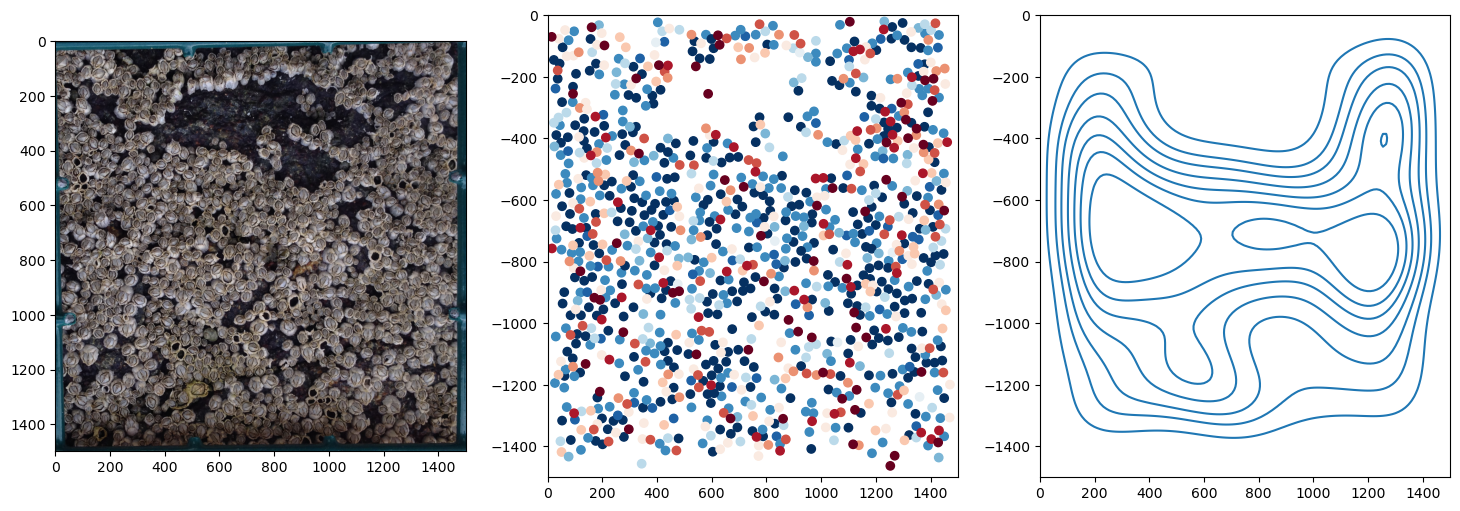

In [27]:
import seaborn as sns

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(Image.open('demo/img_3.png'))

plt.subplot(1, 3, 2)
circles = extract_circles(f"demo/img_3.txt")
x = [x for x,y in circles.keys()]
y = [-y for x,y in circles.keys()]
z = [circles[(x,y)] for x,y in circles.keys()]

cm = plt.cm.get_cmap('RdBu')
plt.scatter(x, y, c=z, cmap=cm)
plt.xlim(0, 1500)
plt.ylim(-1500,0)

plt.subplot(1,3,3)
sns.kdeplot(
    x=x, y=y,
    levels=8, thresh=.3,
)
plt.xlim(0, 1500)
plt.ylim(-1500,0)

plt.show()

Finally, I plotted the relationship between number of barnacles in the image (1/9 of the frame) and barnacle size. Surprisingly, the more dense barnacles had barnacles with a larger radius.

[Text(0.5, 0, 'Number of Barnacles'), Text(0, 0.5, 'Barnacle Radius (cm)')]

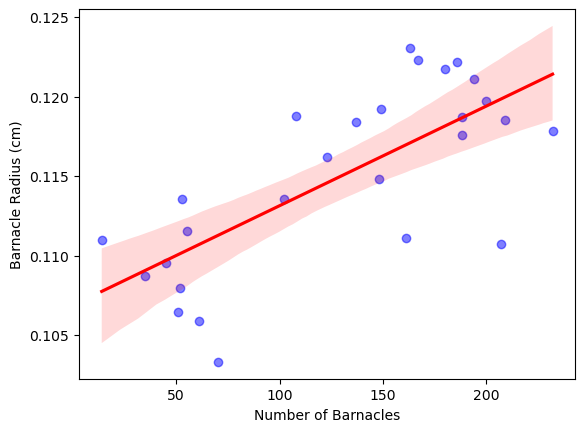

In [28]:
x = []
y = []
# 1500 px to 11.5 cm
for img, count in zip(x_train + x_test, y_train + y_test):
    x.append(count)
    img_id = int(img.split("img_")[1].split("_")[0])
    subsection = int(img.split("_")[-1].split(".jpg")[0])
    estimate = get_estimate(img_id, subsection)
    mean_radius = np.mean(list(estimate.values())) * 11.5/1500
    y.append(mean_radius)

ax = sns.regplot(
    x=x,
    y=y,
    scatter_kws={'color': 'b', 'alpha': 0.5},
    line_kws={'color': 'red'}
)
ax.set(xlabel='Number of Barnacles', ylabel='Barnacle Radius (cm)')